In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 
import shutil
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.utils import class_weight
from PIL import Image

# 1. Load Dataset

In [2]:
test = tf.keras.utils.image_dataset_from_directory("ricosample/labelled/combined/test", image_size=(480, 540), color_mode="grayscale")

Found 946 files belonging to 2 classes.


In [3]:
train = tf.keras.utils.image_dataset_from_directory("ricosample/labelled/combined/train", image_size=(480, 540), color_mode="grayscale")

Found 6622 files belonging to 2 classes.


In [4]:
val = tf.keras.utils.image_dataset_from_directory("ricosample/labelled/combined/val", image_size=(480, 540), color_mode="grayscale")

Found 1892 files belonging to 2 classes.


In [5]:
test = test.map(lambda x,y: (x/255, y))
train = train.map(lambda x,y: (x/255, y))
val = val.map(lambda x,y: (x/255, y))

In [6]:
scaled_iterator = train.as_numpy_iterator()
scaled_batch = scaled_iterator.next()

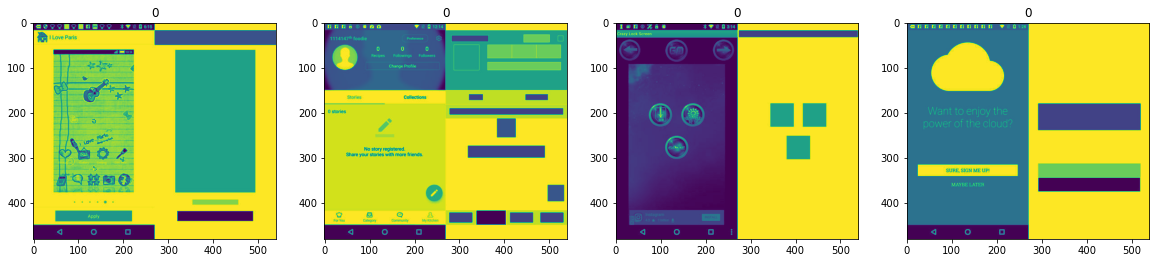

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(scaled_batch[1][idx])

# 2. CNN Model

In [8]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(480,540,1)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model.compile('adagrad', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy', tf.keras.metrics.Precision()])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 538, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 239, 269, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 267, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 118, 133, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 131, 16)      4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 58, 65, 16)       0

In [11]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[callback])

Epoch 1/10
207/207 [==============================] - 491s 2s/step - loss: 0.2551 - accuracy: 0.9165 - precision: 0.0000e+00 - val_loss: 0.2154 - val_accuracy: 0.9181 - val_precision: 0.0000e+00
Epoch 2/10
207/207 [==============================] - 474s 2s/step - loss: 0.1895 - accuracy: 0.9314 - precision: 1.0000 - val_loss: 0.1549 - val_accuracy: 0.9450 - val_precision: 1.0000
Epoch 3/10
207/207 [==============================] - 475s 2s/step - loss: 0.1481 - accuracy: 0.9550 - precision: 0.9735 - val_loss: 0.1277 - val_accuracy: 0.9693 - val_precision: 0.9217
Epoch 4/10
207/207 [==============================] - 474s 2s/step - loss: 0.1341 - accuracy: 0.9618 - precision: 0.9456 - val_loss: 0.1186 - val_accuracy: 0.9641 - val_precision: 0.9579
Epoch 5/10
207/207 [==============================] - 474s 2s/step - loss: 0.1246 - accuracy: 0.9650 - precision: 0.9489 - val_loss: 0.1215 - val_accuracy: 0.9704 - val_precision: 0.8722
Epoch 6/10
207/207 [==============================] - 475

# 3. Evaluation

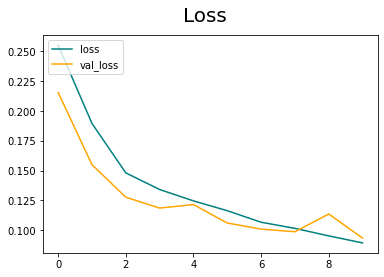

In [12]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

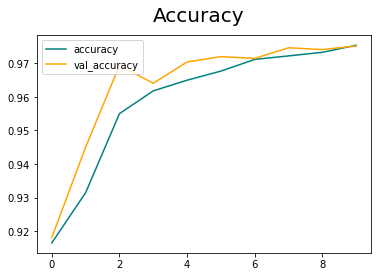

In [13]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [14]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [15]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9591837, shape=(), dtype=float32) tf.Tensor(0.6103896, shape=(), dtype=float32) tf.Tensor(0.96666664, shape=(), dtype=float32)


In [ ]:
path = "models/combined/"
directory = os.fsencode(path)
files = os.listdir(directory)
rows = []

for file in files:
    row = []
    try:
        filename = os.fsdecode(file)
        row.append(filename)
        print(filename)
        model = tf.keras.models.load_model(os.path.join(path, filename))
        pre = Precision()
        re = Recall()
        acc = BinaryAccuracy()
        for batch in test.as_numpy_iterator(): 
            X, y = batch
            yhat = model.predict(X)
            pre.update_state(y, yhat)
            re.update_state(y, yhat)
            acc.update_state(y, yhat)
        row.append(pre.result().numpy())
        row.append(re.result().numpy())
        row.append(acc.result().numpy())
        print(row)
        rows.append(row)
    except:
        print("error: ", file)

In [80]:
results_df = pd.DataFrame(rows)
results_df.columns = ["model", "precision", "recall", "accuracy"]
pd.options.display.max_colwidth = 100
results_df.head(10)

,model,precision,recall,accuracy
0,imageclassifier_fullrico_greyscale_combined_fixedsets_simple_model_small.h5,0.914286,0.415584,0.949190
1,imageclassifier_fullrico_greyscale_combined_fixedsets_simple_model_small_dropout.h5,0.975610,0.519481,0.960417
2,imageclassifier_fullrico_greyscale_combined_fixedsets_small_adagrad.h5,0.938776,0.597403,0.964583
3,imageclassifier_fullrico_greyscale_combined_fixedsets_small_adagrad_epochs.h5,0.981818,0.701299,0.975000
4,imageclassifier_fullrico_greyscale_combined_fixedsets_small_dropout.h5,1.000000,0.584416,0.965046
5,imageclassifier_fullrico_greyscale_combined_fixedsets_small_dropout01_nocallback.h5,0.846154,0.714286,0.966667
6,imageclassifier_fullrico_greyscale_combined_fixedsets_small_simple_adagrad.h5,0.969697,0.415584,0.950463


In [79]:
results_df.to_csv("combined_adagrad_results.csv")

In [16]:
model.save(os.path.join('models','imageclassifier_fullrico_greyscale_combined_fixedsets_small_adagrad_epochs2.h5'))

In [2]:
model = tf.keras.models.load_model('models/imageclassifier_fullrico_greyscale_combined_fixedsets_small_adagrad.h5')

In [ ]:
path = "ricosample/labelled/combined/test/nonside/"
errorpath = "ricosample/labelled/errors/"
directory = os.fsencode(path)
files = os.listdir(directory)
files.sort()
for file in files:
    try:
        filename = os.fsdecode(file)
        print(filename)
        img = cv2.imread(path + filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(img, (540, 480))
        yhat = model.predict(np.expand_dims(resize/255, 0))
        pred = np.rint(yhat)
        if pred == 1:
            shutil.copy(path + filename, errorpath + "false_pos_small_combined_adagrad_10epochs/" + filename)
    except:
        print("error: ", file)

In [ ]:
path = "ricosample/labelled/combined/test/side/"
errorpath = "ricosample/labelled/errors/"
directory = os.fsencode(path)
files = os.listdir(directory)
files.sort()
for file in files:
    try:
        filename = os.fsdecode(file)
        print(filename)
        img = cv2.imread(path + filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(img, (540, 480))
        yhat = model.predict(np.expand_dims(resize/255, 0))
        pred = np.rint(yhat)
        if pred == 0:
            shutil.copy(path + filename, errorpath + "false_neg_small_combined_adagrad_10epochs/" + filename)
    except:
        print("error: ", file)

In [ ]:
path = "ricosample/labelled/screenshots/val/side/"
directory = os.fsencode(path)
path2 = "ricosample/wireframes/"
directory2 = os.fsencode(path2)
path3 = "ricosample/labelled/wireframes/val/side/"
directory3 = os.fsencode(path3)
files = os.listdir(directory)
files.sort()
for file in files:
    try:
        filename = os.fsdecode(file)
        number = filename[:-4]
        wireframepath = path2+number+".png"
        targetpath = path3+number+".png"
        shutil.copy(wireframepath, targetpath)
    except:
        print("error: ", file)

In [30]:
def combine_images(path1, path2, target):
    directory = os.fsencode(path1)
    files = os.listdir(directory)
    files.sort()
    for file in files:
        try:
            filename1 = os.fsdecode(file)
            number = filename1[:-4]
            filename2 = number+".png"
            image1 = Image.open(path1+filename1)
            image2 = Image.open(path2+filename2)
            image1 = image1.resize((270, 480))
            image2 = image2.resize((270, 480))
            image1_size = image1.size
            image2_size = image2.size
            new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))
            new_image.paste(image1,(0,0))
            new_image.paste(image2,(image1_size[0],0))
            new_image.save(target + number + ".jpg","JPEG")
        except:
            print("error: ", file)

In [31]:
combine_images("ricosample/labelled/screenshots/test/nonside/", "ricosample/labelled/wireframes/test/nonside/", "ricosample/labelled/combined/test/nonside/")
combine_images("ricosample/labelled/screenshots/test/side/", "ricosample/labelled/wireframes/test/side/", "ricosample/labelled/combined/test/side/")
combine_images("ricosample/labelled/screenshots/train/nonside/", "ricosample/labelled/wireframes/train/nonside/", "ricosample/labelled/combined/train/nonside/")
combine_images("ricosample/labelled/screenshots/train/side/", "ricosample/labelled/wireframes/train/side/", "ricosample/labelled/combined/train/side/")
combine_images("ricosample/labelled/screenshots/val/nonside/", "ricosample/labelled/wireframes/val/nonside/", "ricosample/labelled/combined/val/nonside/")
combine_images("ricosample/labelled/screenshots/val/side/", "ricosample/labelled/wireframes/val/side/", "ricosample/labelled/combined/val/side/")